In [9]:
import nam

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torch.utils.data import DataLoader

from heart_disease_dataset import HeartDiseaseDataset

In [10]:
batch_size = 32

train_dataset = HeartDiseaseDataset("./preprocessed_heart_train_val.csv")
test_dataset = HeartDiseaseDataset("./preprocessed_heart_test.csv")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

df_train = pd.read_csv("./preprocessed_heart_train_val.csv")
df_test = pd.read_csv("./preprocessed_heart_test.csv")

#Separate features and target
X_train = df_train.drop(columns=['HeartDisease'])
X_test = df_test.drop(columns=['HeartDisease'])
y_train = df_train['HeartDisease']
y_test = df_test['HeartDisease']

X_train

hello
hello


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,Female,ChestPainType is _ATA,ChestPainType is _NAP,ChestPainType is _TA,RestingECG is _LVH,RestingECG is _ST,ST_Slope is _Down,ST_Slope is _Up
0,40.0,140.0,289.0,0.0,172.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,37.0,130.0,283.0,0.0,98.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,48.0,138.0,214.0,0.0,108.0,1.0,1.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54.0,150.0,195.0,0.0,122.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,39.0,120.0,339.0,0.0,170.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,41.0,120.0,157.0,0.0,182.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
730,57.0,140.0,241.0,0.0,123.0,1.0,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
731,45.0,110.0,264.0,0.0,132.0,0.0,1.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
732,68.0,144.0,193.0,1.0,141.0,0.0,3.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
print('X_train.shape=',X_train.shape)
print('y_train.shape=',y_train.shape)
print('X_test.shape=',X_test.shape)
print('y_test.shape=',y_test.shape)

X_train.shape= (734, 15)
y_train.shape= (734,)
X_test.shape= (734, 15)
y_test.shape= (734,)


In [12]:
nam_model = nam.NeuralAdditiveModel(input_size=15,
                            shallow_units=100,
                            hidden_units=(64, 32, 32),
                            shallow_layer=nam.ExULayer,
                            hidden_layer=nam.ReLULayer,
                            hidden_dropout=0.1,
                            feature_dropout=0.1)

print(nam_model)

NeuralAdditiveModel(
  (feature_nns): ModuleList(
    (0-14): 15 x FeatureNN(
      (layers): ModuleList(
        (0): ExULayer()
        (1-3): 3 x ReLULayer()
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (linear): Linear(in_features=32, out_features=1, bias=False)
    )
  )
  (feature_dropout): Dropout(p=0.1, inplace=False)
)


In [13]:
import torch
import torch.optim as optim

optimizer = optim.Adam(nam_model.parameters(), lr=0.001)
loss = torch.nn.BCELoss()
nam_model.train()

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

epochs = 5
for epoch in range(epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        outputs, _ = nam_model(X)
        activation = torch.sigmoid(outputs)
        train_loss = loss(activation, y)
        train_loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

Epoch 1/5, Loss: 0.7404
Epoch 2/5, Loss: 0.9104
Epoch 3/5, Loss: 0.5429
Epoch 4/5, Loss: 0.7217
Epoch 5/5, Loss: 0.8674


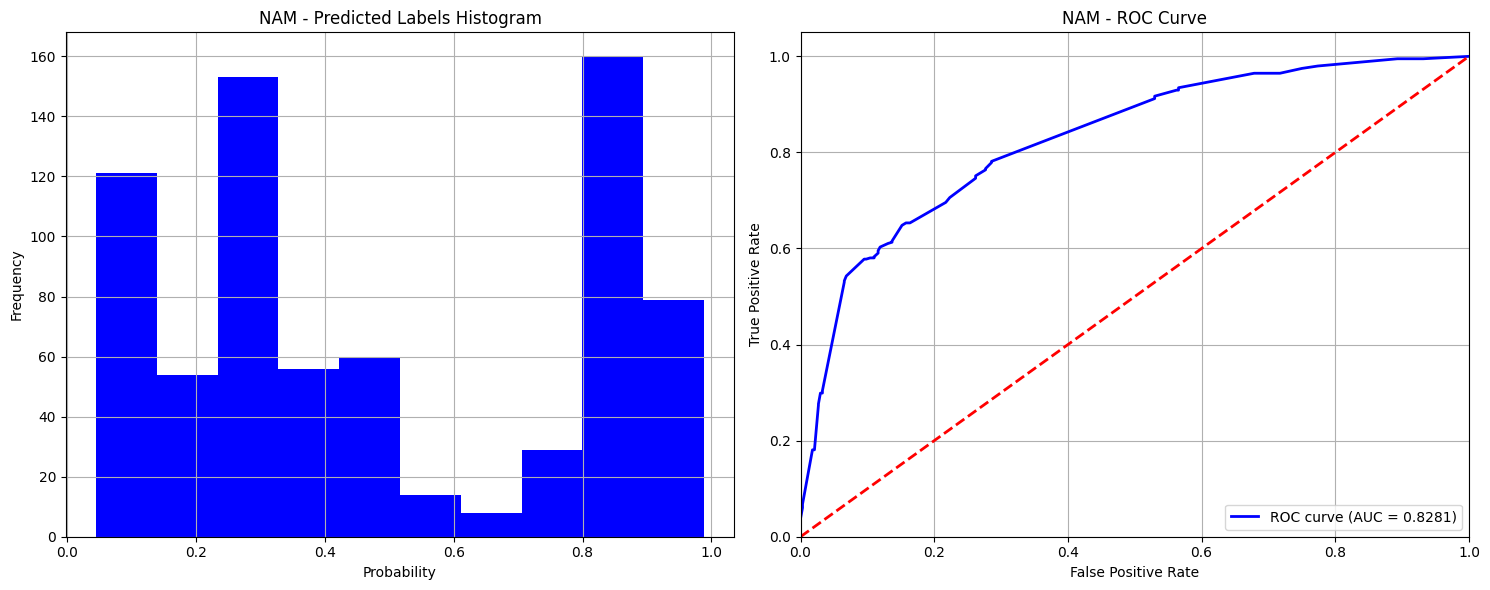

Optimal Threshold: 0.49942774
F1-score: 0.7298444130127298
Balanced Accuracy: 0.7482277458722182


In [14]:
nam_model.eval()

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Predictions
with torch.no_grad():
    for X, y in test_loader:
        inputs = X
        targets = y
        outputs, feature_nn_outputs = nam_model(X)
        activation = torch.sigmoid(outputs)
        activation_per_feature = feature_nn_outputs
        #activation_per_feature = torch.sigmoid(feature_nn_outputs)
    
# Metrics
auc_nam = roc_auc_score(y_test_tensor.numpy(), activation.numpy())

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot predicted labels histogram
axes[0].hist(activation.numpy(), color='b')
axes[0].set_title('NAM - Predicted Labels Histogram')
axes[0].set_xlabel('Probability')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot ROC curve
fpr_nam, tpr_nam, thresholds = roc_curve(y_test_tensor.numpy(), activation.numpy())
axes[1].plot(fpr_nam, tpr_nam, color='b', lw=2, label='ROC curve (AUC = %0.4f)' % auc_nam)
axes[1].plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('NAM - ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Optimal Threshold based on ROC Curve
optimal_idx = np.argmax(tpr_nam - fpr_nam)
optimal_threshold = thresholds[optimal_idx]
print('Optimal Threshold:',optimal_threshold)

predictions_optimal = (activation.numpy() >= optimal_threshold).astype(int)

balanced_accuracy = balanced_accuracy_score(y_test_tensor.numpy(), predictions_optimal)
f1 = f1_score(y_test_tensor.numpy(), predictions_optimal)

print("F1-score:", f1)
print("Balanced Accuracy:", balanced_accuracy)

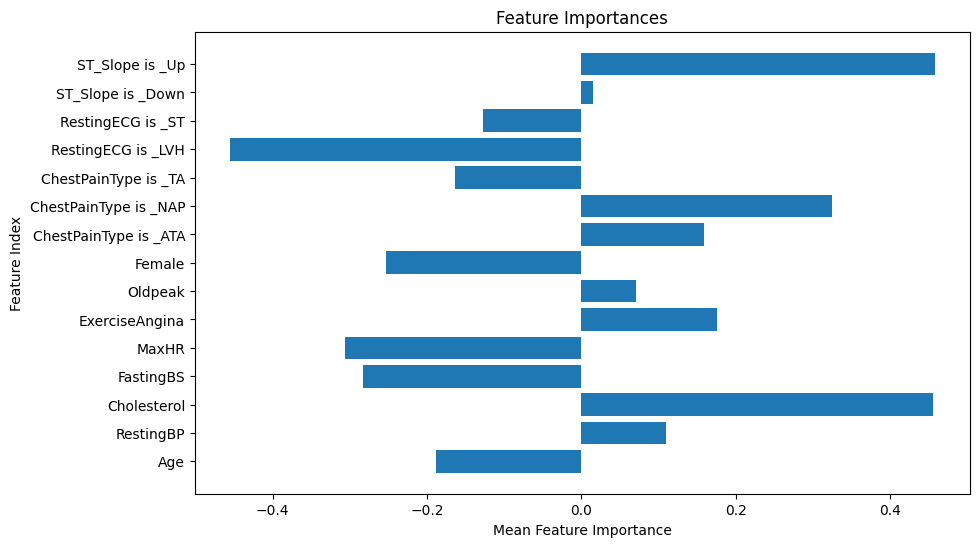

In [15]:
feature_names = X_train.columns.tolist()

# Calculate feature importances
feature_importances = activation_per_feature.numpy()

# Aggregate feature importances
mean_feature_importances = feature_importances.mean(axis=0)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(mean_feature_importances)), mean_feature_importances, align='center')
plt.yticks(range(len(mean_feature_importances)), feature_names)
plt.xlabel('Mean Feature Importance')
plt.ylabel('Feature Index')
plt.title('Feature Importances')
plt.show()

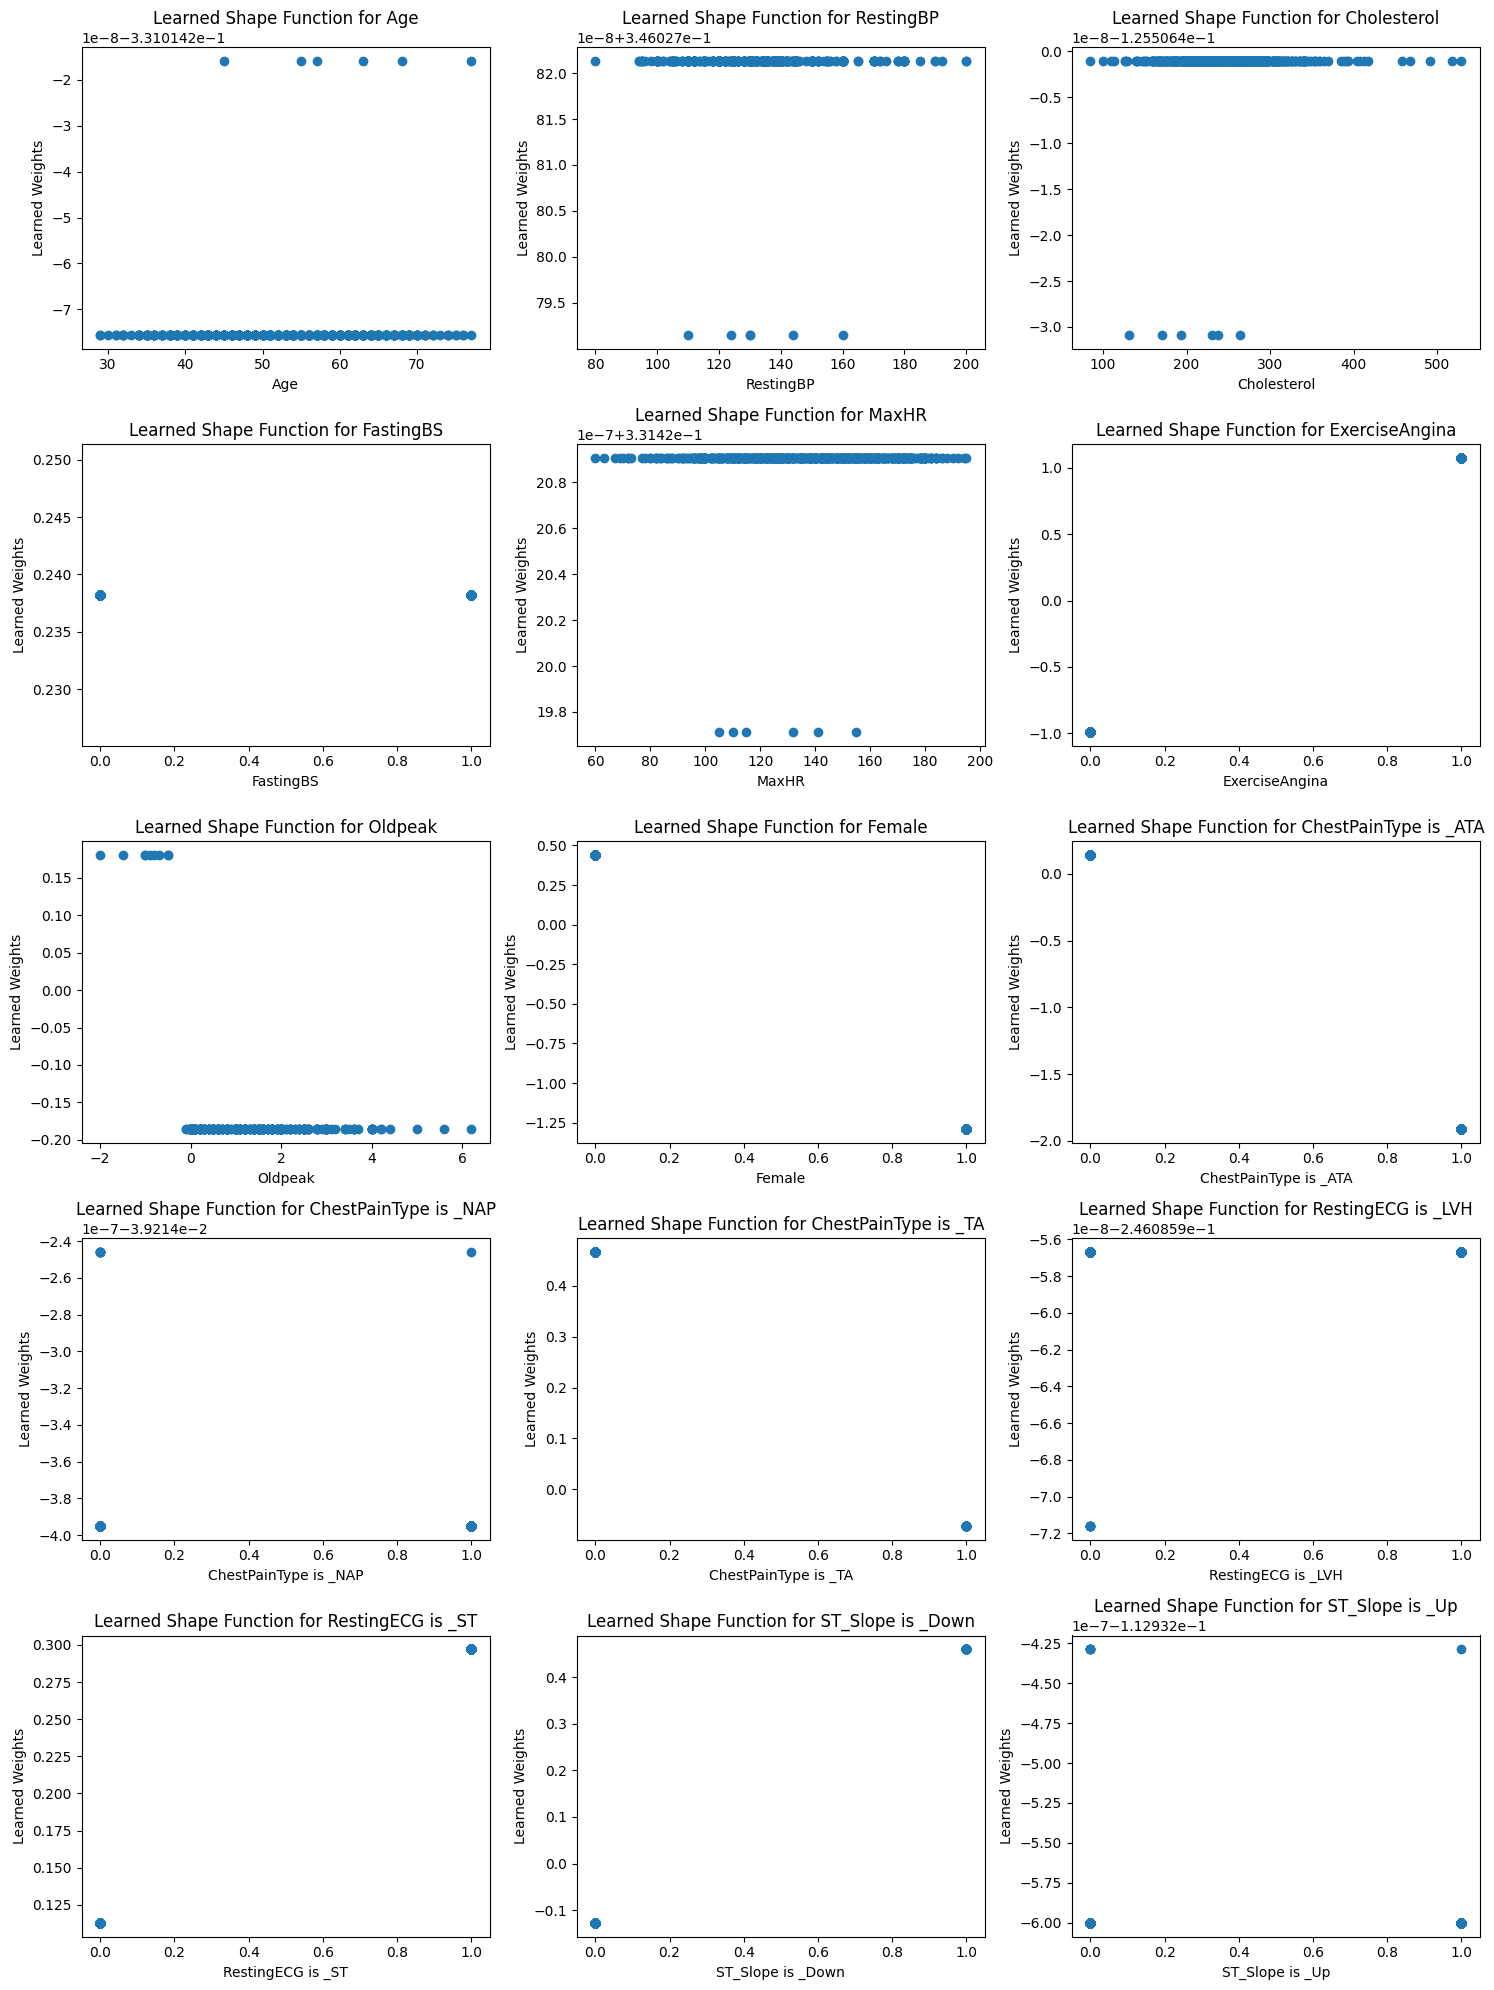

In [8]:
feature_names = X_train.columns.tolist()

# Define the layout for the subplots
num_features = 15
num_rows = 5
num_cols = 3

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

# Flatten the axes for easy indexing
axes = axes.flatten()

# Loop through all features
for i in range(num_features):
    # Extract the learned weights for the current feature
    feature_weights = feature_nn_outputs[:, i].numpy()
    input_features = inputs[:, i].numpy()
    # # Sort the feature values and their corresponding learned weights
    # sorted_indices = np.argsort(X_test.iloc[:, i])
    # sorted_feature_values = X_test.iloc[:, i].iloc[sorted_indices]
    # sorted_weights = feature_weights[sorted_indices]
    # 
    # # Plot the learned shape function
    ax = axes[i]
    # ax.scatter(sorted_feature_values, sorted_weights, color='blue')
    ax.scatter(input_features, feature_weights)
    ax.set_xlabel(feature_names[i])  # Set the feature name as xlabel
    ax.set_ylabel('Learned Weights')
    ax.set_title('Learned Shape Function for ' + feature_names[i])  # Set the feature name as title

# Adjust layout
plt.tight_layout()
plt.show()